# Adventures in mosaic density!

Let's see what happens to optimal filters (a la Atick and Redlich) when we change the density of the mosaic.

In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scipy.optimize as opt
import scipy.signal as ssig
from scipy.interpolate import interp1d
from scipy.special import softmax
import scipy

def softplus(x, beta=1): return np.log1p(np.exp(-np.abs(beta * x)))/beta + np.maximum(x, 0)

plt.rcParams.update({
    "text.usetex": True,
})

sns.set_context('talk')

%config InlineBackend.figure_format = 'retina'

np.random.seed(12346)

# First, let's set up some problem dimensions:

In [5]:
L = 10  # linear size of space in one dimension
T = 5 # size of time
N = 1001 # number of points
M = 1001
zz = np.linspace(-L/2, L/2, N)
tt = np.linspace(-T/2, T/2, M)
dz = zz[1] - zz[0]
dt = tt[1] - tt[0]

# Now assuming $C_x = \frac{A}{k^\alpha\omega^2}$, let's calculate the Atick and Redlich filter.

In [19]:
sigin = 1
sigout = 1.25
A = 100

alpha = 1.3

def soft_bandpass(lo, hi, freqs, stiffness=10):
    if lo <= 0:
        return scipy.special.expit(stiffness * (hi - freqs))
    else:
        return scipy.special.expit(stiffness * (freqs - lo)) * scipy.special.expit(stiffness * (hi - freqs))
    
def C(k, o):
    return A/(np.abs(k)**alpha * np.abs(o)**2)

In [20]:
k_logrange = np.logspace(-3, 11, 100)
o_logrange = np.logspace(-3, 11, 100)
Cx = C(k_logrange,o_logrange)
print(Cx.shape)

(100,)


In [21]:
def filter(A, sigin, sigout, nu, k_lims=None, o_lims=None):
    def v_opt(k, omega):
        sqrt_piece = np.sqrt(1 + (4/nu) * (sigin**2/sigout**2) * k**alpha * omega**2/A)
        v2 = 0.5 * (sqrt_piece + 1) * A / (A + sigin**2 * k**alpha * omega**2) - 1
        v2 = np.sqrt(np.maximum(v2, 0) * sigout**2/sigin**2)
        
        if k_lims:
            unit_cell_k = soft_bandpass(k_lims[0], k_lims[1], k)
            v2 *= unit_cell_k
        if o_lims:
            unit_cell_o = soft_bandpass(o_lims[0], o_lims[1], omega)
            v2 *= unit_cell_o
            
        return v2
    return v_opt

And redefine functions so that the filter can be bandwidth-constrained:

In [22]:
freqs_k = scipy.fft.fftfreq(N, d=dz) * np.pi
freqs_omega = scipy.fft.fftfreq(M, d=dt) * np.pi

freqs_k_small = freqs_k[(freqs_k > 0)]
freqs_omega_small = freqs_omega[(freqs_omega > 0)]

oo, kk = np.meshgrid(freqs_omega_small, freqs_k_small)

In [23]:
nu = 1e-3
vfun = filter(A, sigin, sigout, nu)

C:\Users\David\AppData\Local\Temp\ipykernel_8600\665558838.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.contour(np.log(oo), np.log(kk), np.log10(v), levels=11)


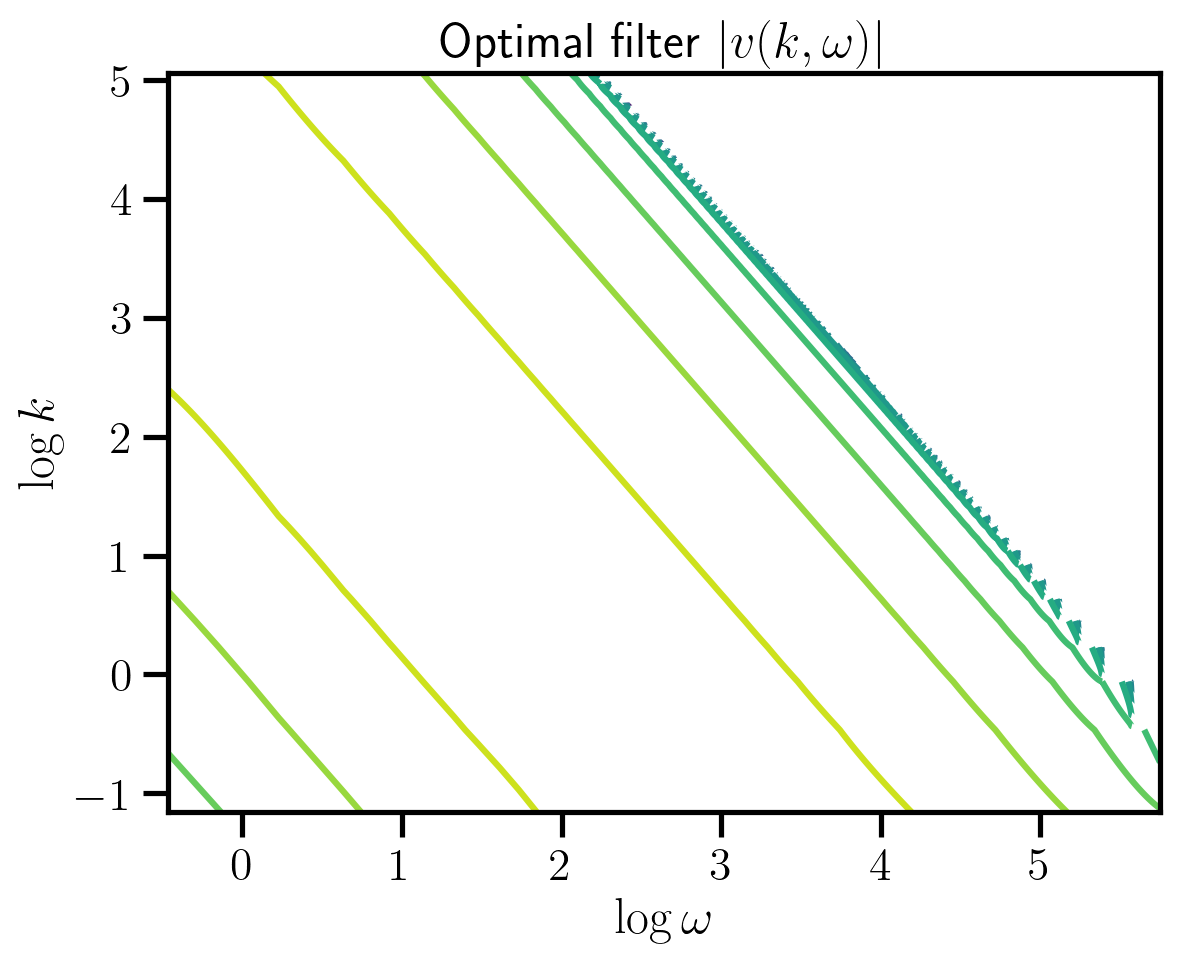

In [24]:
v = vfun(kk, oo)
Ck = C(kk, oo)

plt.contour(np.log(oo), np.log(kk), np.log10(v), levels=11)
plt.title(r"Optimal filter $|v(k, \omega)|$")
plt.ylabel(r"$\log k$")
plt.xlabel(r"$\log \omega$");

# Power as a function of $\nu$

In [25]:
def filter_power(nu, omega0, k_lims):
    vfun = filter(A, sigin, sigout, nu)
    func = lambda k: k * vfun(k, omega0)**2 * (C(k, omega0) + sigin**2)/(2 * np.pi)**2
    return scipy.integrate.quad(func, k_lims[0], k_lims[1])[0]

def filter_power_log_k(nu, omega0, log_k_lims):
    """Integrate power in psi = log k space."""
    vfun = filter(A, sigin, sigout, nu)
    func = lambda psi: np.exp(2 * psi) * vfun(np.exp(psi), omega0**2) * (C(np.exp(psi), omega0) + sigin**2)/(2 * np.pi)**2
    return scipy.integrate.quad(func, log_k_lims[0], log_k_lims[1])[0]

In [26]:
%%time
nu_list = np.logspace(-10, 0, 50) #[1e-6 , 1e-5, 1e-4, 0.005, 0.01, 0.05]

k_lims = (1e-3, 1e3)
omega0 = 10**1.2
pow_list = [filter_power(nu, omega0, k_lims) for nu in nu_list]

CPU times: total: 203 ms
Wall time: 193 ms


# Bringing it all together

C:\Users\David\AppData\Local\Temp\ipykernel_8600\3394520706.py:12: RuntimeWarning: divide by zero encountered in log10
  ax[0, 0].plot(np.log10(k_logrange), np.log10(v2), color='k')
C:\Users\David\AppData\Local\Temp\ipykernel_8600\3394520706.py:23: RuntimeWarning: divide by zero encountered in log10
  ax[0, 0].fill_between(np.log10(k_logrange[right_side]), np.log10(v2[right_side]), -11, color='orange', alpha=0.5, edgecolor='none')
C:\Users\David\AppData\Local\Temp\ipykernel_8600\3394520706.py:50: RuntimeWarning: divide by zero encountered in log10
  ax[0, 1].plot(np.log10(k_logrange), 10 * np.log10(power), label=np.around(np.log10(log_o), 1), color=cmap[idx])
C:\Users\David\AppData\Local\Temp\ipykernel_8600\3394520706.py:65: RuntimeWarning: divide by zero encountered in log10
  ax[1, 1].plot(np.log10(pow_list), np.log10(nu_list), color='k')


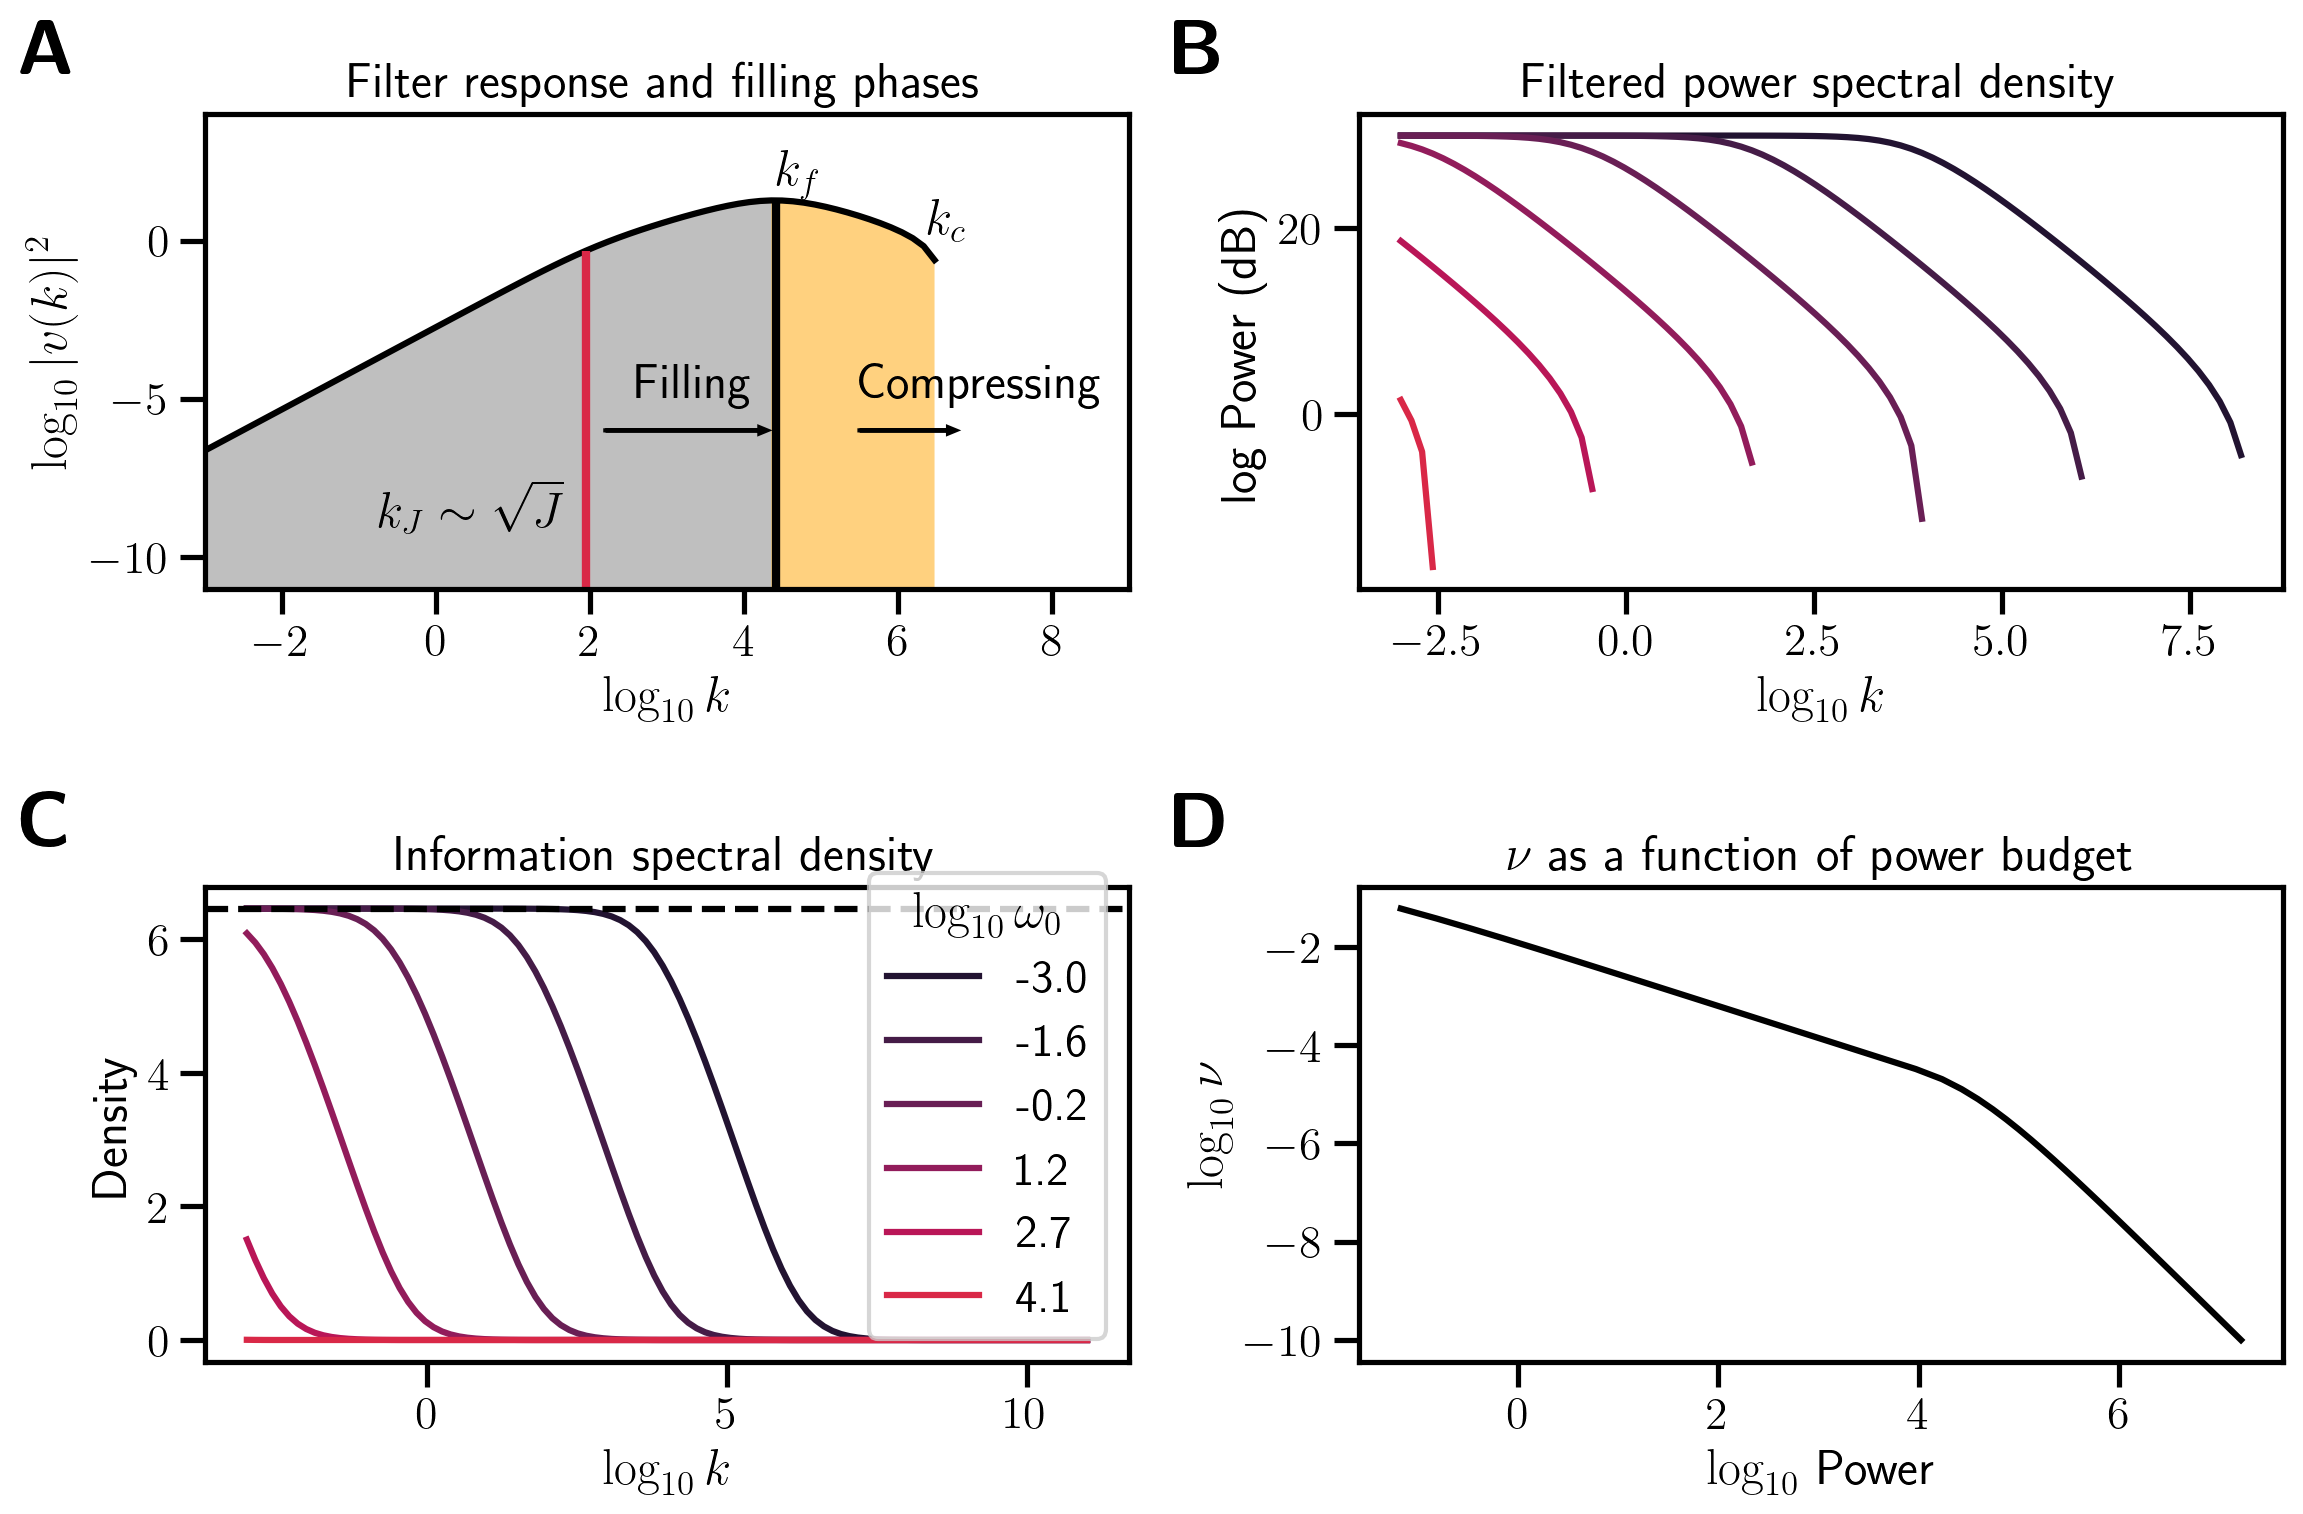

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
cmap = sns.color_palette('rocket', 10)
label_loc = (-0.2, 1.2)
fontsize=28
fontweight='heavy'

k_logrange = np.logspace(-3, 11, 100)
o_logrange = np.logspace(-3, 11, 100)

idx = 8
v2 = vfun(k_logrange, o_logrange[idx])**2
ax[0, 0].plot(np.log10(k_logrange), np.log10(v2), color='k')
log_kp = (np.log10(A) - 2 * np.log10(sigin) - 2 * np.log10(o_logrange[idx]))/alpha
log_v2_kp = 2 * np.log10(vfun(10**log_kp, o_logrange[idx]))
log_kc = log_kp - (np.log10(nu) + 2 * np.log(sigout))/alpha
log_v2_kc = 2 * np.log10(vfun(10**log_kc, o_logrange[idx]))

ax[0, 0].vlines(log_kp, -11, log_v2_kp, color='k', linewidth=3)
nearest_idx = np.argmin(np.abs(k_logrange - 10**log_kp))
left_side = slice(0, nearest_idx + 1) #k_logrange[:nearest_idx] <= 10**log_kp
right_side = slice(nearest_idx, -1) #k_logrange[nearest_idx:] >= 10**log_kp
ax[0, 0].fill_between(np.log10(k_logrange[left_side]), np.log10(v2[left_side]), -11, color='gray', alpha=0.5, edgecolor='none')
ax[0, 0].fill_between(np.log10(k_logrange[right_side]), np.log10(v2[right_side]), -11, color='orange', alpha=0.5, edgecolor='none')
ax[0, 0].set_xlim(-3, 9)
ax[0, 0].set_ylim(-11, 4)
ax[0, 0].annotate(r"Filling", (2.6, -5))
ax[0, 0].arrow(2.2, -6, 2, 0, head_width=0.2, head_length=0.1, color='k')
lower_idx, upper_idx = 35, 70
linecolor = cmap[5] #(227/255, 74/255, 51/255)
ax[0, 0].vlines(np.log10(k_logrange[lower_idx]), -11, np.log10(v2[lower_idx]), color=linecolor, linewidth=3, zorder=2)
# ax[0, 0].vlines(np.log10(k_logrange[upper_idx]), -3.55, np.log10(v2[upper_idx]), color=linecolor, linewidth=3, zorder=1)
# ax[0, 0].vlines(np.log10(k_logrange[upper_idx]), -11, -5.8, color=linecolor, linewidth=3, zorder=1)
ax[0, 0].annotate(r"$k_J \sim \sqrt{J}$", (np.log10(k_logrange[lower_idx]) - 2.7, -9))
ax[0, 0].annotate(r"Compressing", (5.5, -5))
# ax[0, 0].annotate(r"$\frac{\pi}{\Delta z(J)}$", (np.log10(k_logrange[upper_idx]) + .5, -9))
ax[0, 0].arrow(5.5, -6, 1.15, 0, head_width=0.2, head_length=0.1, color='k')
ax[0, 0].annotate(r"$k_f$", (log_kp, log_v2_kp + 0.5))
ax[0, 0].annotate(r"$k_c$", (log_kc, log_v2_kc + 0.5))
ax[0, 0].set_title(r"Filter response and filling phases")
ax[0, 0].set_xlabel(r"$\log_{10} k$")
ax[0, 0].set_ylabel(r"$\log_{10} |v(k)|^2$");
ax[0, 0].text(*label_loc, r'\textbf{A}', transform=ax[0, 0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')


for idx, log_o in enumerate(o_logrange[:60:10]):
    numer = vfun(k_logrange, log_o)**2 * (C(k_logrange, log_o) + sigin**2) + sigout**2
    denom = vfun(k_logrange, log_o)**2 * (sigin**2) + sigout**2
    power = vfun(k_logrange, log_o)**2 * (C(k_logrange, log_o) + sigin**2)
    v2 = vfun(k_logrange, log_o)**2
    ax[0, 1].plot(np.log10(k_logrange), 10 * np.log10(power), label=np.around(np.log10(log_o), 1), color=cmap[idx])
    ax[1, 0].plot(np.log10(k_logrange), np.log(numer) - np.log(denom), label=np.around(np.log10(log_o), 1), color=cmap[idx])

ax[0, 1].set_xlabel(r"$\log_{10} k$")
ax[0, 1].set_ylabel(r"log Power (dB)");
ax[0, 1].set_title(r"Filtered power spectral density");
ax[0, 1].text(*label_loc, r'\textbf{B}', transform=ax[0, 1].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')

ax[1, 0].axhline(-np.log(nu) - np.log(sigout**2), color='k', linestyle='--')
ax[1, 0].set_xlabel(r"$\log_{10} k$")
ax[1, 0].set_ylabel(r"Density")
ax[1, 0].set_title(r"Information spectral density")
ax[1, 0].legend(title=r"$\log_{10} \omega_0$")
ax[1, 0].text(*label_loc, r'\textbf{C}', transform=ax[1, 0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')

ax[1, 1].plot(np.log10(pow_list), np.log10(nu_list), color='k')
ax[1, 1].set_xlabel(r"$\log_{10}$ Power")
ax[1, 1].set_ylabel(r"$\log_{10} \nu$")
ax[1, 1].set_title(r"$\nu$ as a function of power budget")
ax[1, 1].text(*label_loc, r'\textbf{D}', transform=ax[1, 1].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')


plt.tight_layout()
#plt.savefig("figures/k_scaling.pdf")

# Optimal $\nu$ and information as a function of $\omega$:

In [31]:
omega0 = 10**1.2
k = (2 * np.pi/L) * np.array([[0, 0], [1, 0], [1, 0]])
nu = 1e-4

def make_k(J):
    """k is J x 2, with J the number of neurons/frequencies"""
    M = int(np.sqrt(J))  # find biggest square array that fits inside
    m1, m2 = np.meshgrid(range(M), range(M))
    mm = np.stack([m1.ravel(), m2.ravel()], axis=1)
    
    return (2 * np.pi/L) * mm

def filter_power_discrete(nu, omega0, J):
    k = make_k(J)
    
    ktilde = np.linalg.norm(k, axis=1)**alpha * sigin**2 * omega0**2/A

    Pj = np.maximum(0, sigout**2 /(2 * (ktilde + 1e-16)) * (np.sqrt(1 + 4 * ktilde/(nu * sigout**2)) - 1) - sigout**2)
    print(Pj)
    return np.sum(Pj)

In [32]:
def excess_power(lognu, omega0, J, P):
    return np.log(P / np.max([filter_power_discrete(np.exp(lognu), omega0, J), 1e-32]))

def optimal_lognu(omega0, J, P):
    power_constraint = {'type': 'ineq', 'fun': excess_power, 'args': (omega0, J, P)}
    res = opt.minimize(lambda lognu: lognu, -np.log(omega0), #bounds=[(1e-16, np.inf)], 
                       constraints=[power_constraint])
    if res.success:
        return res.x
    else:
        print("Optimizer failed to converge!")
        return None

def information(omega0, J, P):
    log_nu = optimal_lognu(omega0, J, P)
    nu = np.exp(log_nu)
    
    k = make_k(J)
    
    ktilde = np.linalg.norm(k, axis=1)**alpha * sigin**2 * omega0**2/A

    numer = np.maximum(0, sigout**2 /(2 * (ktilde + 1e-16)) * (np.sqrt(1 + 4 * ktilde/(nu * sigout**2)) - 1) - sigout**2) + sigout**2
    
    denom = np.maximum(0, sigout**2 /(2 * (ktilde + 1)) * (np.sqrt(1 + 4 * ktilde/(nu * sigout**2)) + 1) - sigout**2) + sigout**2
    
    return np.sum(np.log(numer) - np.log(denom))

## How do we allocate new neurons across mosaics?

[0.         1.30467579 1.30467579 0.74839493]
[0.         1.30467579 1.30467579 0.74839493]
[0.         1.30467579 1.30467579 0.74839493]
[0.         1.30467577 1.30467577 0.74839491]
[0.         2.08869603 2.08869603 1.37448019]
[0.         2.08869603 2.08869603 1.37448019]
[0.         2.088696   2.088696   1.37448016]
[0.         2.24586951 2.24586951 1.49998255]
[0.         2.24586951 2.24586951 1.49998255]
[0.         2.24586948 2.24586948 1.49998252]
[0.         2.24882676 2.24882676 1.50234388]
[0.         2.24882676 2.24882676 1.50234388]
[0.         2.24882673 2.24882673 1.50234385]
[0.         1.30467579 0.29645114 1.30467579 0.74839493 0.17007588
 0.29645114 0.17007588 0.        ]
[0.         1.30467579 0.29645114 1.30467579 0.74839493 0.17007588
 0.29645114 0.17007588 0.        ]
[0.         1.30467579 0.29645114 1.30467579 0.74839493 0.17007588
 0.29645114 0.17007588 0.        ]
[0.         1.30467577 0.29645113 1.30467577 0.74839491 0.17007586
 0.29645113 0.17007586 0.    

FileNotFoundError: [Errno 2] No such file or directory: 'figures/mosaic_allocation.pdf'

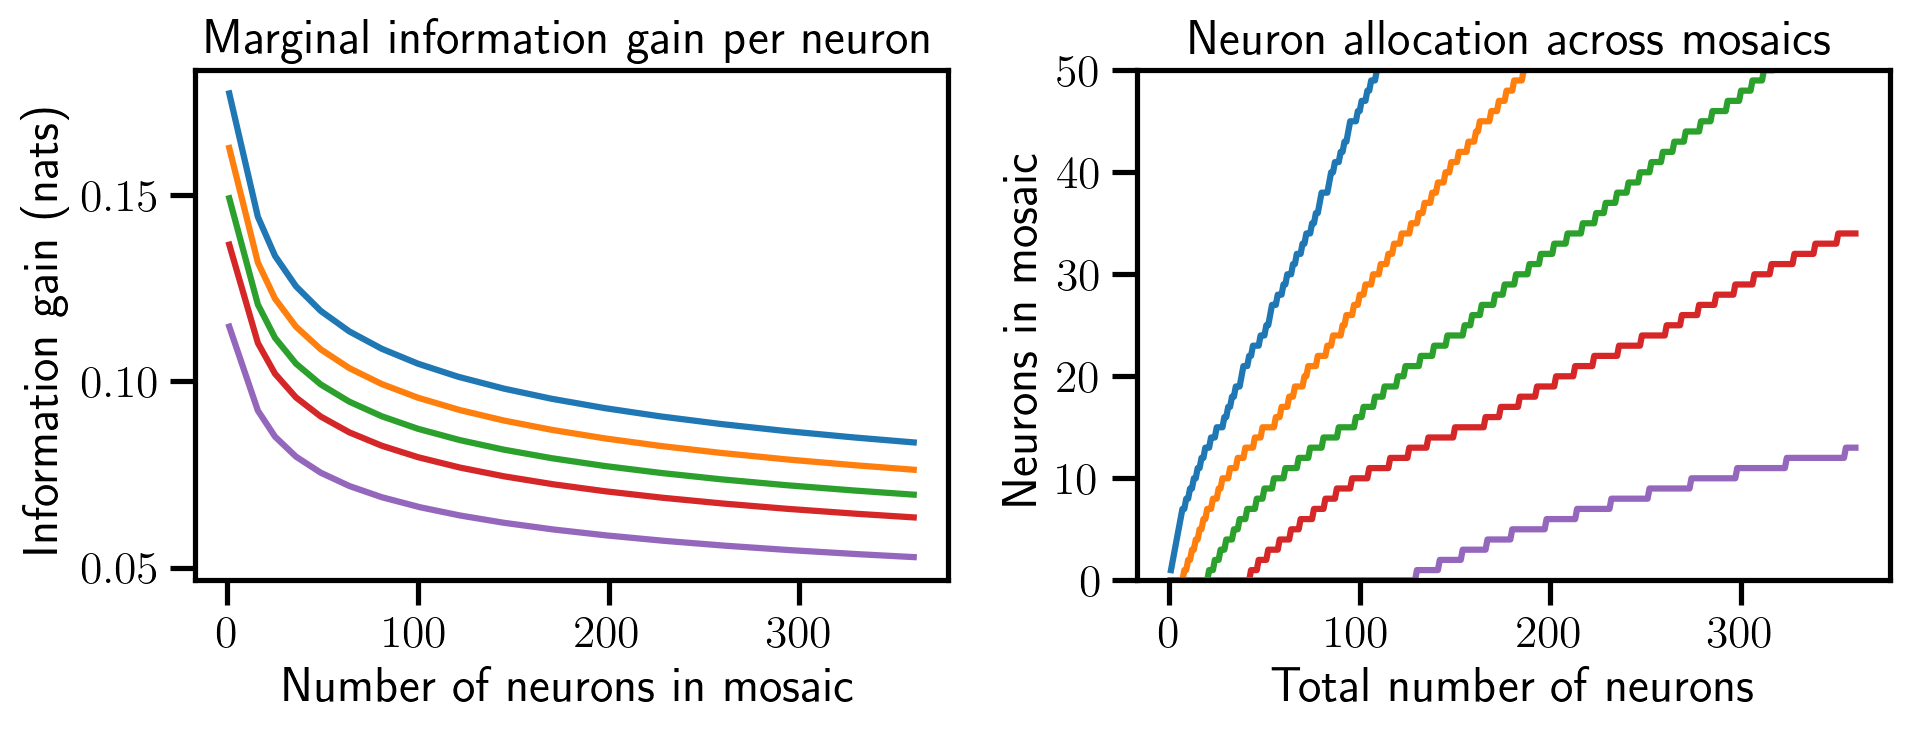

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4)) 

omega0_list = [10**x for x in [1.5, 1.52, 1.54, 1.56, 1.6]]
P0 = 1.5
J_list = [m**2 for m in range(2, 20)]
all_J_list = range(1, J_list[-1])

diff_info_fn_list = []
for omega0 in omega0_list:
    info = [information(omega0, J, J * P0) for J in J_list]
    
    # now interpolate for non-square J
    all_diff_info = interp1d(J_list[1:], np.diff(info), fill_value='extrapolate')
    diff_info_fn_list.append(all_diff_info)
    ax[0].plot(all_J_list, all_diff_info(all_J_list))

ax[0].set_title("Marginal information gain per neuron")
ax[0].set_xlabel("Number of neurons in mosaic")
ax[0].set_ylabel("Information gain (nats)")
    
marginal_allocation = np.zeros((len(all_J_list), len(omega0_list)))
for idx, J in enumerate(all_J_list):
    current_allocation = np.cumsum(marginal_allocation, axis=0)[idx]
    marginal_values = np.array([fun(A + 1) for A, fun in zip(current_allocation, diff_info_fn_list)])
    marginal_allocation[idx, np.argmax(marginal_values)] = 1
    
ax[1].plot(all_J_list, np.cumsum(marginal_allocation, axis=0))
ax[1].set_ylim(0, 50)
ax[1].set_title("Neuron allocation across mosaics")
ax[1].set_xlabel("Total number of neurons")
ax[1].set_ylabel("Neurons in mosaic")

plt.tight_layout()
plt.savefig("figures/mosaic_allocation.pdf")

# Redefine some things to work in the continuous case

We'll define the filter using some different conventions more applicable in the continuous case.

In [14]:
L = 100  # linear size of space in one dimension
T = 50 # size of time
N = 10001 # number of points
M = 10001
zz = np.linspace(-L/2, L/2, N)
tt = np.linspace(-T/2, T/2, M)
dz = zz[1] - zz[0]
dt = tt[1] - tt[0]

freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
freqs_omega = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)
k_low = 0 
o_low = 0 
freqs_k_small = freqs_k[freqs_k > 2 * np.pi * k_low] #[(freqs_k > 0) & (freqs_k < 25)] 
freqs_omega_small = freqs_omega[freqs_omega > 2 * np.pi * o_low] #[(freqs_omega > 0) & (freqs_omega < 25)] 

oo, kk = np.meshgrid(freqs_omega_small, freqs_k_small)
Ck = C(kk, oo)

In [15]:
def filter_k(kf, eps, k_lims=None, power=alpha):
    def v_opt(k):
        sqrt_piece = np.sqrt(1 + (4/eps) * np.abs(k/kf)**power)
        v2 = 0.5 * (sqrt_piece + 1) / (1 + np.abs(k/kf)**power) - 1
        v2 = np.sqrt(np.maximum(v2, 0) * sigout**2/sigin**2)
        
        if k_lims:
            unit_cell_k = soft_bandpass(k_lims[0], k_lims[1], k)
            v2 *= unit_cell_k
        
        return v2
    return v_opt

def filter(C, nu, k_lims=None):
    def v_opt(k, o):
        CC = np.minimum(C(k, o), 1e32)
        sqrt_piece = np.sqrt(CC**2 + (4/nu) * (sigin**2/sigout**2) * CC)
        v2 = 0.5 * (sqrt_piece + CC) / (sigin**2 + CC) - 1
        v2 = np.sqrt(np.maximum(v2, 0) * sigout**2/sigin**2)
        
        if k_lims:
            unit_cell_k = soft_bandpass(k_lims[0], k_lims[1], k)
            v2 *= unit_cell_k
        
        return v2 #- np.min(v2)
    return v_opt

def pad_and_reflect(filter, N, padval=0):
    """
    Zero-pad to length N//2 and reflect about origin to make length N. 
    """
    expanded = np.pad(filter, (0, N//2 + 1 - len(filter)), constant_values=(0, padval))
    return np.concatenate([expanded[::-1], expanded[1:]])

def extrap_and_reflect(filter, N, return_log=False):
    """
    Linearly extrapolate the log filter to better approximate tails and reflect 
    about origin to make length N.
    """
    extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')
    expanded = extrap_fun(range(0, N//2 + 1))
    if not return_log:
        expanded = np.exp(expanded)
    return np.concatenate([expanded[::-1], expanded[1:]])

def filter_power(eps, kf, freqs, klims, power):
    vfun = filter_k(kf, eps, klims, power)
    v2 = vfun(freqs)
    Ck = np.abs(freqs/kf)**power
    dk = freqs[1] - freqs[0]
    return np.sum(v2**2 * np.abs(freqs) * (Ck + sigin**2) * dk)/(2 * np.pi)**2

def excess_power(log_eps, kf, freqs, klims, power, P):
    return P - filter_power(10**log_eps, kf, freqs, klims, power)

def optimal_logeps(kf, freqs, klims, power, P):
    power_constraint = {'type': 'ineq', 'fun': excess_power, 'args': (kf, freqs, klims, power, P)}
    res = opt.minimize(lambda log_eps: log_eps, 0, bounds=[(-16, np.inf)], constraints=[power_constraint])
    if res.success:
        return res.x
    else:
        print("Optimizer failed to converge!")
        return None

<ipython-input-15-1e4d769afe85>:40: RuntimeWarning: divide by zero encountered in log
  extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')
<ipython-input-15-1e4d769afe85>:40: RuntimeWarning: divide by zero encountered in log
  extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')
<ipython-input-15-1e4d769afe85>:40: RuntimeWarning: divide by zero encountered in log
  extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')
<ipython-input-15-1e4d769afe85>:40: RuntimeWarning: divide by zero encountered in log
  extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')
<ipython-input-15-1e4d769afe85>:40: RuntimeWarning: divide by zero encountered in log
  extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')


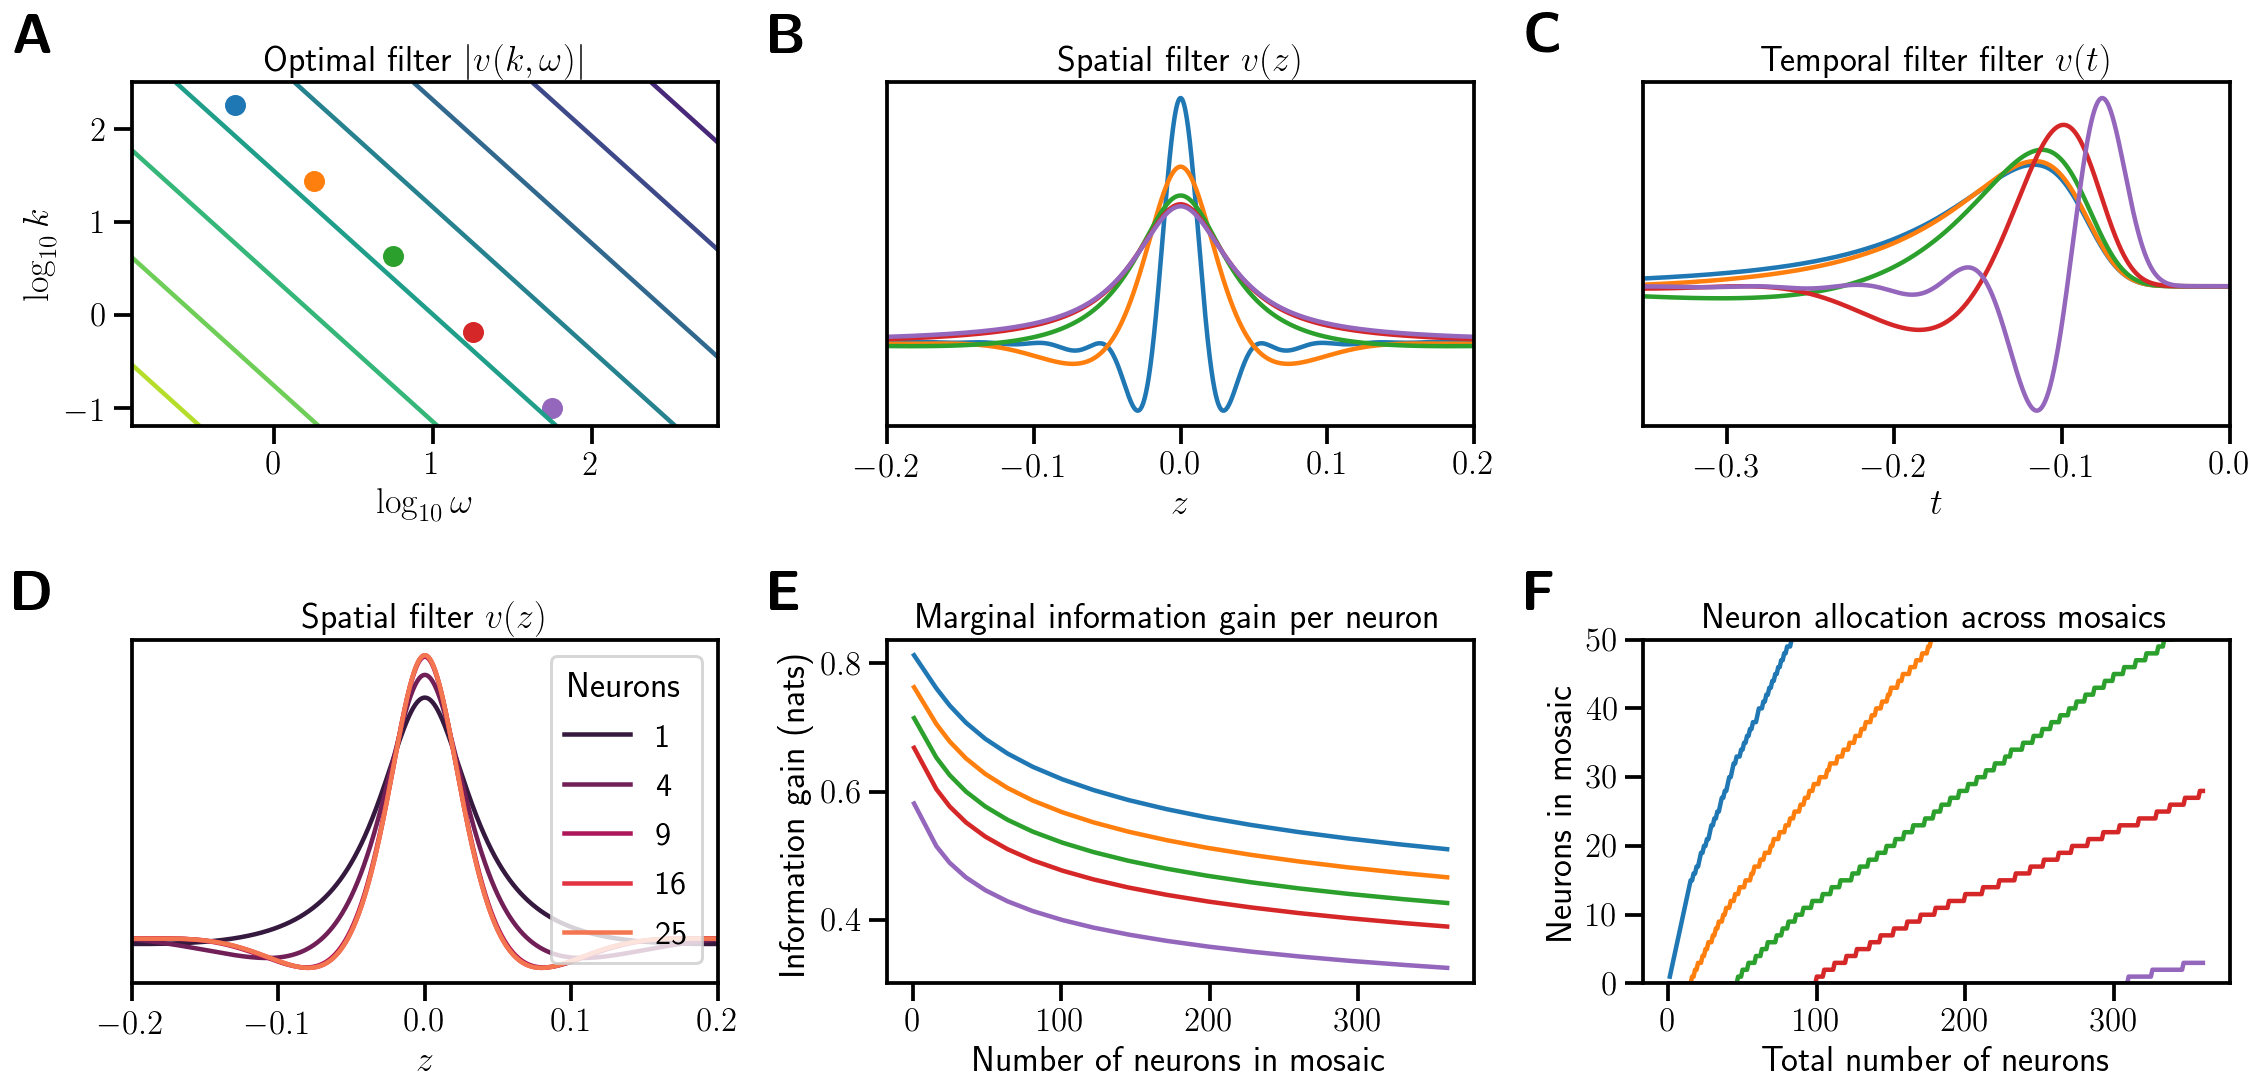

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
k0_list = [10**k0 for k0 in np.linspace(2.25, -1, 5)]
o0_list = [10**o0 for o0 in np.linspace(-0.25, 1.75, 5)]
kf_list = [(A/sigin**2/o0**2)**(1/alpha) for o0 in o0_list]
of_list = [np.sqrt(A/sigin**2/k0**alpha) for k0 in k0_list]

vfun = filter(C, 1e-4)

ax[0, 0].contour(np.log10(oo), np.log10(kk), np.log10(Ck), levels=10)
ax[0, 0].set_title(r"Optimal filter $|v(k, \omega)|$")
ax[0, 0].set_ylabel(r"$\log_{10} k$")
ax[0, 0].set_xlabel(r"$\log_{10} \omega$");
ax[0, 0].text(*label_loc, r'\textbf{A}', transform=ax[0, 0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')

for kf, of in zip(kf_list, of_list):
    o0 = np.sqrt(A/sigin**2/kf**alpha)
    k0 = (A/sigin**2/of**2)**(1/alpha)
    ax[0, 0].scatter(np.log10(o0), np.log10(k0))
    
P = 1
dz = 1e-4
N = 1000001
freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
L = (N//2) * dz
zz = np.linspace(-L/2, L/2, N)

# make a double exponential smoothing filter
fz = np.arange(-.2, .2, dz)
ff = np.exp(-50 * np.abs(fz))
ff /= np.sum(ff)

for kf in kf_list:
    log_eps = optimal_logeps(kf, freqs_k, None, alpha, P)
    vv = filter_k(kf, 10**log_eps)(freqs_k)
    vf = np.convolve(vv[N//2:], ff, mode='same')
    vvf = pad_and_reflect(vf, N)
    vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
    vspace /= np.linalg.norm(vspace)
    
    ax[0, 1].plot(zz, vspace)

ax[0, 1].set_xlim(-0.2, 0.2)   
ax[0, 1].set_yticks([])
ax[0, 1].set_xlabel(r"$z$")
ax[0, 1].set_title(r"Spatial filter $v(z)$");
ax[0, 1].text(*label_loc, r'\textbf{B}', transform=ax[0, 1].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')



dt = 1e-4
M = 1000001
freqs_o = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)
T = (M//2) * dt
tt = np.linspace(-T/2, T/2, M)

for of in of_list:
    log_eps = optimal_logeps(of, freqs_o, None, 2, P)
    vv = filter_k(of, 10**log_eps, power=2)(freqs_o)
    vf = np.convolve(vv[M//2:], ff, mode='same')
    log_v = extrap_and_reflect(vf, M, return_log=True)
    log_v_a = np.conj(ssig.hilbert(log_v))
    vt = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(np.exp(log_v_a)))))
    vt /= np.linalg.norm(vt)
    
    ax[0, 2].plot(tt, vt)

ax[0, 2].set_xlim(-0.35, 0)
ax[0, 2].set_xlabel(r"$t$")
ax[0, 2].set_yticks([])
ax[0, 2].set_title(r"Temporal filter filter $v(t)$");
ax[0, 2].text(*label_loc, r'\textbf{C}', transform=ax[0, 2].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')


cmap = sns.color_palette('rocket')
kf = 50

J_list = [1, 4, 9, 16, 25]
for idx, J in enumerate(J_list):
    k_lims = (0, np.sqrt(J) * 8)
    log_eps = optimal_logeps(kf, freqs_k, k_lims, alpha, P)
    vv = filter_k(kf, 10**log_eps, k_lims)(freqs_k)
    vf = np.convolve(vv[N//2:], ff, mode='same')
    vvf = pad_and_reflect(vf, N)
    vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
    vspace /= np.linalg.norm(vspace)    
    ax[1, 0].plot(zz, vspace, color=cmap[idx], label=J)

ax[1, 0].set_xlim(-0.2, 0.2)
ax[1, 0].set_yticks([])
ax[1, 0].set_xlabel(r"$z$")
ax[1, 0].set_title(r"Spatial filter $v(z)$")
ax[1, 0].legend(title="Neurons", loc='upper right')
ax[1, 0].text(*label_loc, r'\textbf{D}', transform=ax[1, 0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')



for idx in range(len(diff_info_fn_list)):
    all_diff_info = diff_info_fn_list[idx]
    ax[1, 1].plot(all_J_list, all_diff_info(all_J_list))

ax[1, 1].set_title("Marginal information gain per neuron")
ax[1, 1].set_xlabel("Number of neurons in mosaic")
ax[1, 1].set_ylabel("Information gain (nats)")
ax[1, 1].text(*label_loc, r'\textbf{E}', transform=ax[1, 1].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    
ax[1, 2].plot(all_J_list, np.cumsum(marginal_allocation, axis=0))
ax[1, 2].set_ylim(0, 50)
ax[1, 2].set_title("Neuron allocation across mosaics")
ax[1, 2].set_xlabel("Total number of neurons")
ax[1, 2].set_ylabel("Neurons in mosaic")
ax[1, 2].text(*label_loc, r'\textbf{F}', transform=ax[1, 2].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')

plt.tight_layout()
plt.savefig("figures/optimal_linear_spacetime.pdf")